# Lapsers only model

## Set up

In [1]:
##Import functions

import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import pandas as pd

##Import sklearn models & metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression,RidgeClassifierCV, LassoCV, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.svm import SVR, SVC    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
%%time
#Load data

client = boto3.client(
    's3',
    aws_access_key_id = '',
    aws_secret_access_key = '',
    region_name = 'us-east-2'
)

obj = client.get_object(
    Bucket = 'predicthealth-aetna',
    Key = 'merged_clean_08-07.csv'
)

df1 = pd.read_csv(obj['Body'], low_memory=False)
df1.head()

CPU times: user 7.89 s, sys: 2.1 s, total: 9.99 s
Wall time: 1min 3s


,Contract,Sales.Channel.Nm,N2NCY,C210MYS,C210MAH,C210PWH,C210PHI,C210PBL,C210HMI,C210CIP,...,Count.of.Calls,Voluntary.Disenrollment,elapsedMonths,Birth.Dt_age,BDOC_months_ago,FSALDATE_months_ago,BLSTORDR_months_ago,BLONORDR_months_ago,BLOFORDR_months_ago,RORDERDT_months_ago
0,H4835,HEALTHSPIRE,A,4_,49.0,81.0,18.0,2.0,82.0,72.0,...,NaN,NaN,18.0,78.0,NaN,226.0,28.0,NaN,28.0,NaN
1,H4835,NDP,A,5_,53.0,83.0,15.0,3.0,104.0,86.0,...,NaN,NaN,18.0,77.0,NaN,109.0,6.0,NaN,6.0,NaN
2,H4835,NDP,A,5_,68.0,86.0,19.0,1.0,75.0,66.0,...,NaN,NaN,18.0,71.0,NaN,42.0,NaN,NaN,NaN,NaN
3,H4835,NDP,A,3_,50.0,58.0,59.0,7.0,43.0,23.0,...,NaN,NaN,18.0,75.0,110.0,NaN,40.0,NaN,40.0,NaN
4,H4835,NDP,A,4_,48.0,81.0,19.0,3.0,96.0,82.0,...,NaN,NaN,0.0,64.0,NaN,22.0,NaN,NaN,NaN,NaN


In [3]:
## Data cleaning

df = df1.copy(deep=False)
df = df.loc[df['Lapsed']==1]
var_details = pd.read_csv('var_details.csv')
vars_cat = var_details.loc[(var_details.VarType=="categorical") & (var_details.Drop=="No")]
vars_cat = vars_cat['Variable'].dropna()
df = df.drop(['RMUSIC', 'RPHOTO', 'RVIDDVD'], axis = 1)
df_cols = df.columns
vars_cat = [x for x in vars_cat if x in df_cols]
df = pd.get_dummies(df, columns = vars_cat)
df['Voluntary.Disenrollment'] = np.where((df['Voluntary.Disenrollment'] != "No "),1, 0)
df = df.loc[((df['Voluntary.Disenrollment'] == 0) & (df.elapsedMonths>12)) | (df['Voluntary.Disenrollment']==1)]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35493 entries, 0 to 35492
Columns: 1719 entries, index to EarlyLapser
dtypes: float64(195), int64(3), uint8(1521)
memory usage: 105.1 MB
None
0.0    27194
1.0     8299
Name: EarlyLapser, dtype: int64
1    35493
Name: Lapsed, dtype: int64
1    31184
0     4309
Name: Voluntary.Disenrollment, dtype: int64


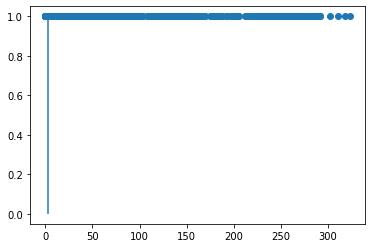

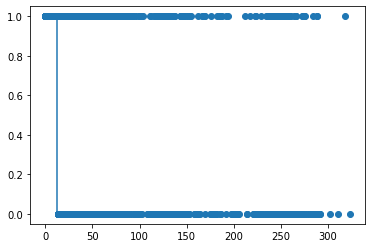

In [4]:
## Create & summarize 3 month lapse model

df_3month = df.copy(deep=False)
df_3month.loc[df_3month.elapsedMonths<=3, ('EarlyLapser')] = 1
df_3month.loc[df_3month.elapsedMonths>3, ('EarlyLapser')] = 0
df_3month = df_3month.reset_index()

print(df_3month.info())
print(df_3month['EarlyLapser'].value_counts())
print(df_3month['Lapsed'].value_counts())
print(df_3month['Voluntary.Disenrollment'].value_counts())

plt.scatter(df_3month['elapsedMonths'], df_3month['Lapsed'])
plt.vlines(x=3, ymin=0, ymax=1)
plt.show()

plt.scatter(df_3month['elapsedMonths'], df_3month['Voluntary.Disenrollment'])
plt.vlines(x=12, ymin=0, ymax=1)
plt.show()

0.0    24804
1.0    10689
Name: EarlyLapser, dtype: int64
1    35493
Name: Lapsed, dtype: int64
1    31184
0     4309
Name: Voluntary.Disenrollment, dtype: int64


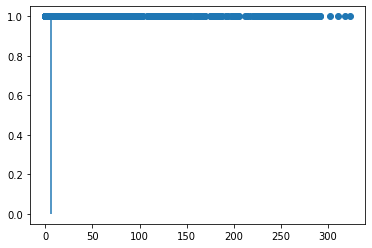

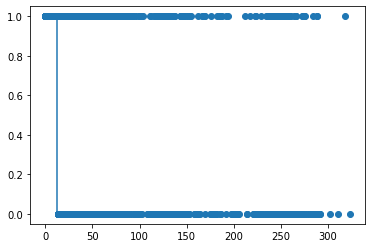

In [5]:
## Create & summarize 6 month lapse model

df_6month = df.copy()
df_6month.loc[df_6month.elapsedMonths<=6, ('EarlyLapser')] = 1
df_6month.loc[df_6month.elapsedMonths>6, ('EarlyLapser')] = 0
df_6month = df_6month.reset_index()

print(df_6month['EarlyLapser'].value_counts())
print(df_6month['Lapsed'].value_counts())
print(df_6month['Voluntary.Disenrollment'].value_counts())

plt.scatter(df_6month['elapsedMonths'], df_6month['Lapsed'])
plt.vlines(x=6, ymin=0, ymax=1)
plt.show()

plt.scatter(df_6month['elapsedMonths'], df_6month['Voluntary.Disenrollment'])
plt.vlines(x=12, ymin=0, ymax=1)
plt.show()

1.0    24254
0.0    11239
Name: EarlyLapser, dtype: int64
1    35493
Name: Lapsed, dtype: int64
1    31184
0     4309
Name: Voluntary.Disenrollment, dtype: int64


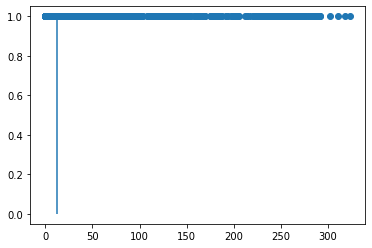

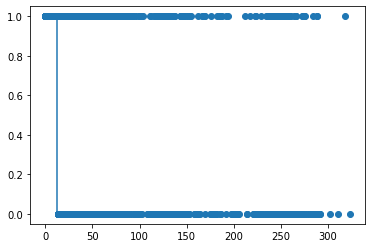

In [6]:
## Create & summarize 1 year lapse model

df_1year = df.copy()
df_1year.loc[df_1year.elapsedMonths<=12, ('EarlyLapser')] = 1
df_1year.loc[df_1year.elapsedMonths>12, ('EarlyLapser')] = 0
df_1year = df_1year.reset_index()


print(df_1year['EarlyLapser'].value_counts())
print(df_1year['Lapsed'].value_counts())
print(df_1year['Voluntary.Disenrollment'].value_counts())

plt.scatter(df_1year['elapsedMonths'], df_1year['Lapsed'])
plt.vlines(x=12, ymin=0, ymax=1)
plt.show()

plt.scatter(df_1year['elapsedMonths'], df_1year['Voluntary.Disenrollment'])
plt.vlines(x=12, ymin=0, ymax=1)
plt.show()

In [7]:
##Define functions

def categorical_evaluation(y_test, y_pred):
    
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("AUC:", round(roc_auc, 2))
    print("ROC Curve: ")
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Model')
    display.plot()  
    plt.show()
    print("F1 Score: {}", round(f1_score(y_test, y_pred), 4))
    print("All Model Metrics: \n", classification_report(y_test, y_pred))
    print("Model Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    return None
   

def continuous_evaluation(y_test, y_pred):
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("AUC:", round(roc_auc, 2))
    print("ROC Curve: ")
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Model')
    display.plot()  
    plt.show()

    thresh = np.linspace(0,1,1001)
    f1_scores = []
    for i in range(len(thresh)):
        f1_scores.append(f1_score(y_test, classify(y_pred, thresh[i])))
         
    max_index = f1_scores.index(max(f1_scores))
    thresholdOpt = thresh[max_index]   
    print('Best Threshold: {}'.format(thresholdOpt))
    print("F1 Score: ", f1_score(y_test, classify(y_pred, thresholdOpt)))        
    print("All Model Metrics: \n", classification_report(y_test, classify(y_pred, thresholdOpt)))
    print("Model Confusion Matrix: \n", confusion_matrix(y_test, classify(y_pred, thresholdOpt)))
    
    return None

def classify_decision_boundary(y_test, y_pred):
    
    thresh = np.linspace(0,1,1001)
    f1_scores = []
    for i in range(len(thresh)):
        f1_scores.append(f1_score(y_test, classify(y_pred, thresh[i])))
         
    max_index = f1_scores.index(max(f1_scores))
    thresholdOpt = thresh[max_index]
    y = classify(y_pred, thresholdOpt)
    return y

def classify(y, x):
    conditions = [(y >= x),
             (y < x)]
    values = [1.0, 0.0]
    y = np.select(conditions, values)
    return y

def upsampler(x, y):
    
    x= pd.DataFrame(x)
    training = pd.concat([x, y], axis = 1)
    EarlyLapser = training[training.EarlyLapser==1]
    Retained = training[training.EarlyLapser==0]
              
    if (len(EarlyLapser[0]) < len(Retained[0])):
        
        EarlyLapser_upsampled = resample(EarlyLapser,
                                replace=True, # sample with replacement
                                n_samples=len(Retained), # match number in majority class
                                random_state=27, stratify = EarlyLapser) # reproducible results
        upsampled = pd.concat([EarlyLapser_upsampled, Retained])
    else:
        Retained_upsampled = resample(Retained,
                                replace=True, # sample with replacement
                                n_samples=len(EarlyLapser), # match number in majority class
                                random_state=27, stratify = Retained) # reproducible results
        upsampled = pd.concat([EarlyLapser, Retained_upsampled])
        
    y_upsampled = upsampled['EarlyLapser']
    x_upsampled = upsampled.drop('EarlyLapser', axis=1)
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(x_upsampled)
    x_upsampled = imp_median.transform(x_upsampled)
    return(x_upsampled, y_upsampled)

def downsampler(x, y):
    
    x= pd.DataFrame(x)
    training = pd.concat([x, y], axis = 1)    
    EarlyLapser = training[training.EarlyLapser==1]
    Retained = training[training.EarlyLapser==0]
    
    if (len(EarlyLapser[0]) < len(Retained[0])):
        Retained_downsampled = resample(Retained,
                                replace=False, # sample without replacement
                                n_samples=len(EarlyLapser), # match number in majority class
                                random_state=27, stratify = Retained) # reproducible results
        downsampled = pd.concat([EarlyLapser, Retained_downsampled])
    else:
        EarlyLapser_downsampled = resample(EarlyLapser,
                                replace=False, # sample with replacement
                                n_samples=len(Retained), # match number in majority class
                                random_state=27, stratify = EarlyLapser) # reproducible results

        downsampled = pd.concat([EarlyLapser_downsampled, Retained])
        
    y_downsampled = downsampled['EarlyLapser']
    x_downsampled = downsampled.drop('EarlyLapser', axis=1)
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(x_downsampled)
    x_downsampled = imp_median.transform(x_downsampled)
    return(x_downsampled, y_downsampled)



In [8]:
%%time
##Create train test split

#3 month
y_3month = df_3month['EarlyLapser']
x_3month = df_3month.drop(['EarlyLapser', 'elapsedMonths', 'Lapsed', 'Voluntary.Disenrollment'], axis = 1)

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(x_3month)
x_3month = imp_median.transform(x_3month)

x_train_3month, x_test_3month, y_train_3month, y_test_3month = train_test_split(x_3month, y_3month, test_size=0.2, random_state=0)

#6 month

y_6month = df_6month['EarlyLapser']
x_6month = df_6month.drop(['EarlyLapser', 'elapsedMonths', 'Lapsed', 'Voluntary.Disenrollment'], axis = 1)

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(x_6month)
x_6month = imp_median.transform(x_6month)

x_train_6month, x_test_6month, y_train_6month, y_test_6month = train_test_split(x_6month, y_6month, test_size=0.2, random_state=0)

y_1year = df_1year['EarlyLapser']
x_1year = df_1year.drop(['EarlyLapser', 'elapsedMonths', 'Lapsed', 'Voluntary.Disenrollment'], axis = 1)

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(x_1year)
x_1year = imp_median.transform(x_1year)

x_train_1year, x_test_1year, y_train_1year, y_test_1year = train_test_split(x_1year, y_1year, test_size=0.2, random_state=0)

CPU times: user 29.5 s, sys: 8.12 s, total: 37.7 s
Wall time: 41.3 s


In [9]:
%%time
## Create upsamples and downsamples
x_3month_upsampled, y_3month_upsampled = upsampler(x_3month, y_3month)
x_3month_downsampled, y_3month_downsampled = downsampler(x_3month, y_3month)
x_train_3month_upsampled, x_test_3month_upsampled, y_train_3month_upsampled, y_test_3month_upsampled = train_test_split(x_3month_upsampled, y_3month_upsampled, test_size=0.2, random_state=0)
x_train_3month_downsampled, x_test_3month_downsampled, y_train_3month_downsampled, y_test_3month_downsampled = train_test_split(x_3month_downsampled, y_3month_downsampled, test_size=0.2, random_state=0)


x_6month_upsampled, y_6month_upsampled = upsampler(x_6month, y_6month)
x_6month_downsampled, y_6month_downsampled = downsampler(x_6month, y_6month)
x_train_6month_upsampled, x_test_6month_upsampled, y_train_6month_upsampled, y_test_6month_upsampled = train_test_split(x_6month_upsampled, y_6month_upsampled, test_size=0.2, random_state=0)
x_train_6month_downsampled, x_test_6month_downsampled, y_train_6month_downsampled, y_test_6month_downsampled = train_test_split(x_6month_downsampled, y_6month_downsampled, test_size=0.2, random_state=0)


x_1year_upsampled, y_1year_upsampled = upsampler(x_1year, y_1year)
x_1year_downsampled, y_1year_downsampled = downsampler(x_1year, y_1year)
x_train_1year_upsampled, x_test_1year_upsampled, y_train_1year_upsampled, y_test_1year_upsampled = train_test_split(x_1year_upsampled, y_1year_upsampled, test_size=0.2, random_state=0)
x_train_1year_downsampled, x_test_1year_downsampled, y_train_1year_downsampled, y_test_1year_downsampled = train_test_split(x_1year_downsampled, y_1year_downsampled, test_size=0.2, random_state=0)


CPU times: user 3min 18s, sys: 32.9 s, total: 3min 51s
Wall time: 4min 3s


In [10]:
%%time
##Create validation set

x_train_3month_val, x_test_3month_val, y_train_3month_val, y_test_3month_val = train_test_split(x_3month, y_3month, test_size=0.05, random_state=0)
x_train_6month_val, x_test_6month_val, y_train_6month_val, y_test_6month_val = train_test_split(x_6month, y_6month, test_size=0.05, random_state=0)
x_train_1year_val, x_test_1year_val, y_train_1year_val, y_test_1year_val = train_test_split(x_1year, y_1year, test_size=0.05, random_state=0)

CPU times: user 5.54 s, sys: 1.9 s, total: 7.44 s
Wall time: 7.81 s


## Logistic Regression Model

### 3 month model - regular

0.70 accuracy with a standard deviation of 0.00
AUC: 0.74
ROC Curve: 


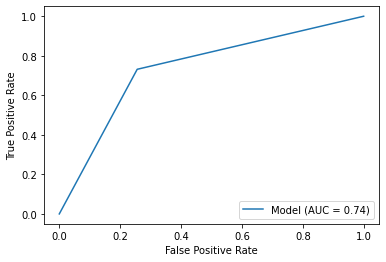

F1 Score: {} 0.5718
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      5422
         1.0       0.47      0.73      0.57      1677

    accuracy                           0.74      7099
   macro avg       0.68      0.74      0.69      7099
weighted avg       0.80      0.74      0.76      7099

Model Confusion Matrix: 
 [[4034 1388]
 [ 450 1227]]
CPU times: user 1min 11s, sys: 2.16 s, total: 1min 13s
Wall time: 1min 15s


In [11]:
%%time
#Logistic Regression Model w/ stochastic gradient descent

clf_3month = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_3month, y_train_3month)
y_pred_3month_log = clf_3month.predict(np.array(x_test_3month))

scores = cross_val_score(clf_3month, x_test_3month_val, y_test_3month_val, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (round(scores.mean(),2), round(scores.std(), 2)))

categorical_evaluation(y_test_3month, y_pred_3month_log)


### 3 month model - upsampled

0.69 accuracy with a standard deviation of 0.03
AUC: 0.77
ROC Curve: 


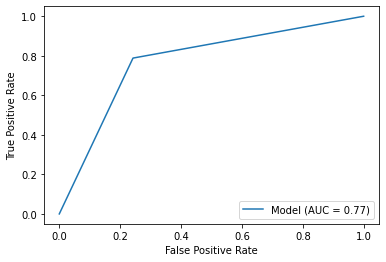

F1 Score: {} 0.6132
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.92      0.76      0.83      5422
         1.0       0.50      0.79      0.61      1677

    accuracy                           0.77      7099
   macro avg       0.71      0.77      0.72      7099
weighted avg       0.82      0.77      0.78      7099

Model Confusion Matrix: 
 [[4109 1313]
 [ 355 1322]]
CPU times: user 1min 16s, sys: 2.2 s, total: 1min 18s
Wall time: 1min 18s


In [12]:
%%time
clf_3month_upsampled = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_3month_upsampled, y_train_3month_upsampled)
y_pred_3month_log_upsampled = clf_3month_upsampled.predict(np.array(x_test_3month))

scores = cross_val_score(clf_3month_upsampled, x_test_3month_val, y_test_3month_val, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (round(scores.mean(),2), round(scores.std(), 2)))

categorical_evaluation(y_test_3month, y_pred_3month_log_upsampled)

### 6 month model - regular

0.66 accuracy with a standard deviation of 0.01
AUC: 0.74
ROC Curve: 


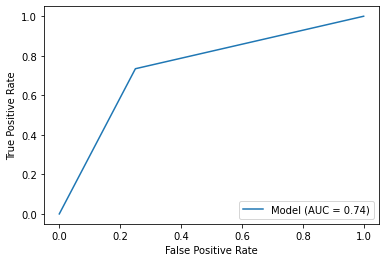

F1 Score: {} 0.6336
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      4971
         1.0       0.56      0.73      0.63      2128

    accuracy                           0.75      7099
   macro avg       0.71      0.74      0.72      7099
weighted avg       0.78      0.75      0.75      7099

Model Confusion Matrix: 
 [[3728 1243]
 [ 565 1563]]
CPU times: user 1min 11s, sys: 1.78 s, total: 1min 13s
Wall time: 1min 12s


In [13]:
%%time
##Logistic Regression Model w/ stochastic gradient descent

clf_6month = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_6month, y_train_6month)
y_pred_6month_log = clf_6month.predict(np.array(x_test_6month))

scores = cross_val_score(clf_6month, x_test_6month_val, y_test_6month_val, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (round(scores.mean(),2), round(scores.std(), 2)))

categorical_evaluation(y_test_6month, y_pred_6month_log)


### 6 month model - upsampled

0.66 accuracy with a standard deviation of 0.01
AUC: 0.77
ROC Curve: 


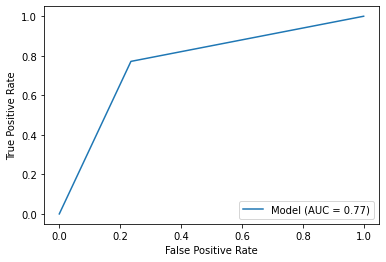

F1 Score: {} 0.6648
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.89      0.76      0.82      4971
         1.0       0.58      0.77      0.66      2128

    accuracy                           0.77      7099
   macro avg       0.74      0.77      0.74      7099
weighted avg       0.80      0.77      0.77      7099

Model Confusion Matrix: 
 [[3801 1170]
 [ 486 1642]]


In [14]:
clf_6month_upsampled = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_6month_upsampled, y_train_6month_upsampled)
y_pred_6month_log_upsampled = clf_6month_upsampled.predict(np.array(x_test_6month))

scores = cross_val_score(clf_6month_upsampled, x_test_6month_val, y_test_6month_val, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (round(scores.mean(),2), round(scores.std(), 2)))

categorical_evaluation(y_test_6month, y_pred_6month_log_upsampled)

### 1 year model - regular

0.59 accuracy with a standard deviation of 0.01
AUC: 0.67
ROC Curve: 


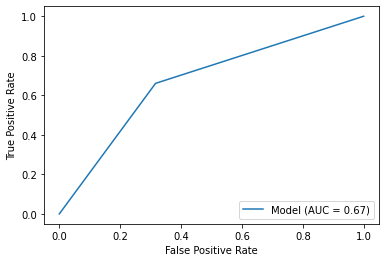

F1 Score: {} 0.7326
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.48      0.68      0.56      2207
         1.0       0.82      0.66      0.73      4892

    accuracy                           0.67      7099
   macro avg       0.65      0.67      0.65      7099
weighted avg       0.71      0.67      0.68      7099

Model Confusion Matrix: 
 [[1509  698]
 [1661 3231]]
CPU times: user 1min 3s, sys: 1.74 s, total: 1min 5s
Wall time: 1min 5s


In [15]:
%%time
##Logistic Regression Model w/ stochastic gradient descent

clf_1year = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_1year, y_train_1year)
y_pred_1year_log = clf_1year.predict(np.array(x_test_1year))


scores = cross_val_score(clf_1year, x_test_1year_val, y_test_1year_val, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (round(scores.mean(),2), round(scores.std(), 2)))

categorical_evaluation(y_test_1year, y_pred_1year_log)

### 1 year model - upsampled

0.60 accuracy with a standard deviation of 0.01
AUC: 0.7
ROC Curve: 


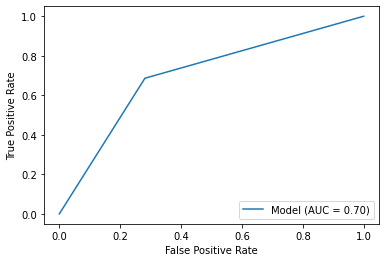

F1 Score: {} 0.7571
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.51      0.72      0.60      2207
         1.0       0.84      0.69      0.76      4892

    accuracy                           0.70      7099
   macro avg       0.68      0.70      0.68      7099
weighted avg       0.74      0.70      0.71      7099

Model Confusion Matrix: 
 [[1586  621]
 [1534 3358]]


In [16]:
clf_1year_upsampled = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log', warm_start = True, learning_rate = 'adaptive', eta0 = 0.1, max_iter = 10000, penalty = 'elasticnet', class_weight = 'balanced')).fit(x_train_1year_upsampled, y_train_1year_upsampled)
y_pred_1year_log_upsampled = clf_1year_upsampled.predict(np.array(x_test_1year))

scores = cross_val_score(clf_1year_upsampled, x_test_1year_val, y_test_1year_val, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (round(scores.mean(),2), round(scores.std(), 2)))

categorical_evaluation(y_test_1year, y_pred_1year_log_upsampled)

## Linear Regression (Lasso)

### 3 month model - upsampled

AUC: 0.81
ROC Curve: 


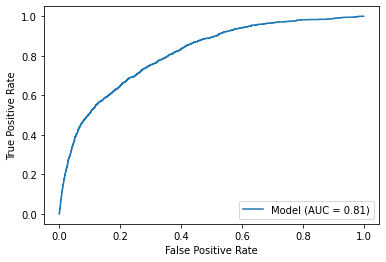

Best Threshold: 0.35000000000000003
F1 Score:  0.5689500448698772
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      5422
         1.0       0.57      0.57      0.57      1677

    accuracy                           0.80      7099
   macro avg       0.72      0.72      0.72      7099
weighted avg       0.80      0.80      0.80      7099

Model Confusion Matrix: 
 [[4707  715]
 [ 726  951]]
CPU times: user 3min 14s, sys: 10.4 s, total: 3min 25s
Wall time: 3min 33s


In [17]:
%%time
##Linear Regression Model w/ Lasso Regularizer

model = make_pipeline(StandardScaler(), LassoCV(max_iter = 10000, normalize = True, selection = "random")).fit(x_train_3month, y_train_3month)
y_pred_3month_lasso = model.predict(np.array(x_test_3month))

continuous_evaluation(y_test_3month, y_pred_3month_lasso)


### 3 month model - upsampled

AUC: 0.84
ROC Curve: 


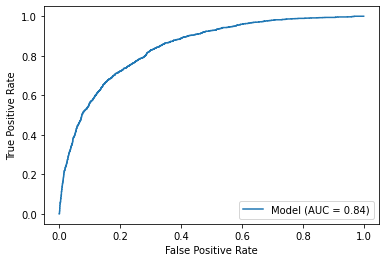

Best Threshold: 0.584
F1 Score:  0.6177606177606177
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.89      0.85      0.87      5422
         1.0       0.57      0.67      0.62      1677

    accuracy                           0.80      7099
   macro avg       0.73      0.76      0.74      7099
weighted avg       0.82      0.80      0.81      7099

Model Confusion Matrix: 
 [[4593  829]
 [ 557 1120]]
CPU times: user 2min 26s, sys: 10.9 s, total: 2min 37s
Wall time: 1min 55s


In [18]:
%%time
##Upsampled Linear Regression Model w/ Lasso regularizer

modellasso_3month_upsampled = make_pipeline(StandardScaler(), LassoCV(max_iter = 10000, selection = "random")).fit(x_train_3month_upsampled, y_train_3month_upsampled)
y_pred_3month_lasso_upsampled = modellasso_3month_upsampled.predict(np.array(x_test_3month))

continuous_evaluation(y_test_3month, y_pred_3month_lasso_upsampled)

### 6 month model - regular

AUC: 0.82
ROC Curve: 


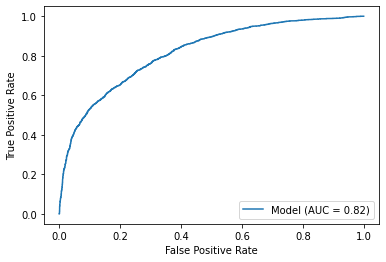

Best Threshold: 0.334
F1 Score:  0.6236125126135217
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.86      0.74      0.80      4971
         1.0       0.55      0.73      0.62      2128

    accuracy                           0.74      7099
   macro avg       0.71      0.73      0.71      7099
weighted avg       0.77      0.74      0.75      7099

Model Confusion Matrix: 
 [[3689 1282]
 [ 583 1545]]
CPU times: user 2min 12s, sys: 7.93 s, total: 2min 19s
Wall time: 1min 41s


In [19]:
%%time
##Linear Regression Model w/ Lasso Regularizer

model = make_pipeline(StandardScaler(), LassoCV(max_iter = 10000, normalize = True, selection = "random")).fit(x_train_6month, y_train_6month)
y_pred_6month_lasso = model.predict(np.array(x_test_6month))

continuous_evaluation(y_test_6month, y_pred_6month_lasso)


### 6 month model - upsampled

AUC: 0.84
ROC Curve: 


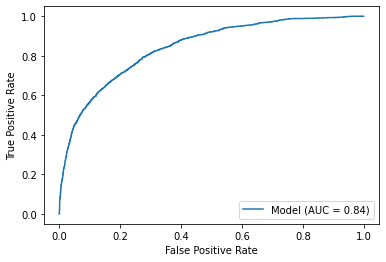

Best Threshold: 0.482
F1 Score:  0.6510999614048629
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.89      0.73      0.80      4971
         1.0       0.55      0.79      0.65      2128

    accuracy                           0.75      7099
   macro avg       0.72      0.76      0.73      7099
weighted avg       0.79      0.75      0.75      7099

Model Confusion Matrix: 
 [[3604 1367]
 [ 441 1687]]
CPU times: user 2min 24s, sys: 9.98 s, total: 2min 34s
Wall time: 1min 50s


In [20]:
%%time
##Upsampled Linear Regression Model w/ Lasso regularizer

modellasso_6month_upsampled = make_pipeline(StandardScaler(), LassoCV(max_iter = 10000, selection = "random")).fit(x_train_6month_upsampled, y_train_6month_upsampled)
y_pred_6month_lasso_upsampled = modellasso_6month_upsampled.predict(np.array(x_test_6month))

continuous_evaluation(y_test_6month, y_pred_6month_lasso_upsampled)

### 1 year model - regular

AUC: 0.75
ROC Curve: 


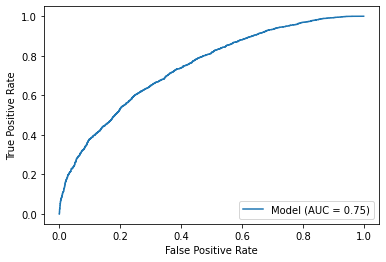

Best Threshold: 0.46
F1 Score:  0.8318848213501886
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.74      0.20      0.32      2207
         1.0       0.73      0.97      0.83      4892

    accuracy                           0.73      7099
   macro avg       0.74      0.59      0.57      7099
weighted avg       0.73      0.73      0.67      7099

Model Confusion Matrix: 
 [[ 446 1761]
 [ 154 4738]]
CPU times: user 3min 18s, sys: 10.5 s, total: 3min 28s
Wall time: 2min 56s


In [21]:
%%time
##Linear Regression Model w/ Lasso Regularizer

model = make_pipeline(StandardScaler(), LassoCV(max_iter = 10000, normalize = True, selection = "random")).fit(x_train_1year, y_train_1year)
y_pred_1year_lasso = model.predict(np.array(x_test_1year))

continuous_evaluation(y_test_1year, y_pred_1year_lasso)


### 1 year model - upsampled

AUC: 0.77
ROC Curve: 


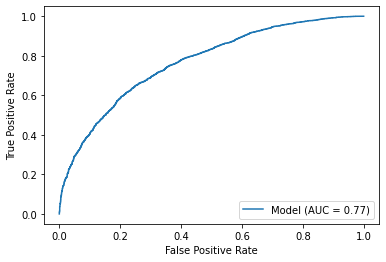

Best Threshold: 0.312
F1 Score:  0.8368359339767296
All Model Metrics: 
               precision    recall  f1-score   support

         0.0       0.72      0.29      0.42      2207
         1.0       0.75      0.95      0.84      4892

    accuracy                           0.75      7099
   macro avg       0.73      0.62      0.63      7099
weighted avg       0.74      0.75      0.71      7099

Model Confusion Matrix: 
 [[ 651 1556]
 [ 253 4639]]
CPU times: user 3min 9s, sys: 11.6 s, total: 3min 20s
Wall time: 2min 41s


In [22]:
%%time
##Upsampled Linear Regression Model w/ Lasso regularizer

modellasso_1year_upsampled = make_pipeline(StandardScaler(), LassoCV(max_iter = 100000, random_state=6)).fit(x_train_1year_upsampled, y_train_1year_upsampled)
y_pred_1year_lasso_upsampled = modellasso_1year_upsampled.predict(np.array(x_test_1year))

continuous_evaluation(y_test_1year, y_pred_1year_lasso_upsampled)